### step01

In [1]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

data = np.array(1.0)
x = Variable(data)
print(x.data)

x.data = np.array(2.0)
print(x.data)


1.0
2.0


### step02

In [2]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
x = Variable(np.array(10))
f = Square()
y = f(x)
print(type(y))
print(y.data)


<class '__main__.Variable'>
100


### step03

In [9]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
class Exp(Function):
    def forward(self, x):
        return np.exp(x)
    

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
print(y.data)


1.648721270700128


### step04

In [10]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
class Exp(Function):
    def forward(self, x):
        return np.exp(x)

def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)

f = Square() # type: ignore
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy)

def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)


4.000000000004
3.2974426293330694


### step05

In [11]:
# no code

### step06

In [12]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    
class Exp(Function):
    def forward(self, x):
        return np.exp(x)
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx
    
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)


3.297442541400256


### step07

In [13]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        f = self.creator # 1. 함수를 가져온다.
        if f is not None:
            x = f.input # 2. 함수의 입력을 가져온다.
            x.grad = f.backward(self.grad) # 3. 함수의 backward 메서드를 호출한다.
            x.backward() # 하나 앞 변수의 backward 메서드를 호출한다. (재귀)

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        output.set_creator(self) # 출력 변수에 creator 설정
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    
class Exp(Function):
    def forward(self, x):
        return np.exp(x)
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx
    
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()
print(x.grad)


3.297442541400256


### step08

In [14]:
import numpy as np

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            x, y = f.input, f.output # 2. 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(y)
        output.set_creator(self) # 출력 변수에 creator 설정
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx
    
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


### step09

In [15]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            x, y = f.input, f.output # 2. 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(as_array(y)) # 출력도 변수로 만든다.
        output.set_creator(self) # 출력 변수에 creator 설정
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()
    
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx
    
def square(x):
    return Square()(x)

def exp(x):
    return Exp()(x)

x = Variable(np.array(0.5))
y = square(exp(square(a)))
y.backward()
print(x.grad)

x = Variable(np.array(1.0))
x = Variable(None)
x = Variable(1.0)

None


TypeError: <class 'float'> is not supported

### step10

In [ ]:
import unittest
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            x, y = f.input, f.output # 2. 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
        output = Variable(as_array(y)) # 출력도 변수로 만든다.
        output.set_creator(self) # 출력 변수에 creator 설정
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    
def square(x):
    return Square()(x)

def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)


class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
    
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)
        
    def test_gradient_check(self):
        x = Variable(np.random.rand(1)) # 무작위 입력값 생성
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

### step11

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            x, y = f.input, f.output # 2. 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, input):
        xs = [x.data for x in input]
        ys = self.forward(xs) # 구체적인 계산은 forward 메서드에서 한다.
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = input
        self.outputs = output
        return outputs
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)
    

xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)


5


### step12

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            x, y = f.input, f.output # 2. 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(xs) # 구체적인 계산은 forward 메서드에서 한다.
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = output
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)
    

def add(x0, x1):
    return Add()(x0, x1)


x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


### step13

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                x.grad = gx
            
                if x.creator is not None:
                    funcs.append(x.creator)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx
    
def square(x):
    return Square()(x)

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return (y,)
    
    def backward(self, gy):
        return gy, gy
    

def add(x0, x1):
    return Add()(x0, x1)


x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(x.grad)
print(y.grad)



13.0
4.0
6.0


### step14

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    funcs.append(x.creator)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
        
def add(x0, x1):
    return Add()(x0, x1)


x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(y.grad)

x = Variable(np.array(3.0))
y = add(add(x, x), x)
y.backward()
print(x.grad)

1.0
3.0


### step15

In [ ]:
# no code

### step16

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다.
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.
        
        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx
        

def square(x):
    return Square()(x)



class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    
def add(x0, x1):
    return Add()(x0, x1)


x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()
print(y.data)
print(x.grad)



32.0
64.0


### step17

In [ ]:
import weakref
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다.
    
    def backward(self):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.
        
        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs] # 수정 전
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx
    

def square(x):
    return Square()(x)


for i in range(10):
    x = Variable(np.random.randn(10000))
    y = square(square(square(x)))
    print(i, x.data)
    print(i, y.data)

0 [ 0.51523039 -0.6337819   0.9496101  ...  1.09644694  1.72385847
  2.24566012]
0 [4.96605797e-03 2.60326662e-02 6.61245318e-01 ... 2.08881974e+00
 7.79853209e+01 6.46773497e+02]
1 [ 0.68399541 -0.24123982  0.00918078 ... -1.36486381  1.08001168
  1.42408723]
1 [4.79099259e-02 1.14707530e-05 5.04702083e-17 ... 1.20424415e+01
 1.85109036e+00 1.69158073e+01]
2 [-0.78259104 -0.8945965  -0.67289481 ...  1.01991569  0.3961439
  0.19372485]
2 [1.40695094e-01 4.10220682e-01 4.20317437e-02 ... 1.17088482e+00
 6.06490160e-04 1.98373035e-06]
3 [-2.1857383   1.59562546  0.77809424 ...  0.80699822 -0.24354509
  1.19141533]
3 [5.20937120e+02 4.20191882e+01 1.34356164e-01 ... 1.79879058e-01
 1.23775586e-05 4.05980767e+00]
4 [ 0.49835395 -0.91411366  1.50214689 ... -2.02103163 -1.25750745
  0.13232218]
4 [3.80454956e-03 4.87530297e-01 2.59238331e+01 ... 2.78345940e+02
 6.25294398e+00 9.39855716e-08]
5 [-0.56582299 -1.27140044 -0.5779604  ... -0.24486001  0.7002786
 -0.09042963]
5 [1.05061776e-02 6.8

### step18

In [ ]:
import weakref
import numpy as np
import contextlib

class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name) # Config 클래스의 enable_backprop 속성을 가져온다.
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다.
    
    def backward(self, retain_grad=False):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.
        
        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs] # 수정 전
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx
    

def square(x):
    return Square()(x)


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    

def add(x0, x1):
    return Add()(x0, x1)


x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()
print(y.grad, t.grad)
print(x0.grad, x1.grad)

with using_config('enable_backprop', False):
    x = Variable(np.array(2.0))
    y = square(x)


with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)



None None
2.0 1.0


### step19

In [ ]:
import weakref
import numpy as np
import contextlib

class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config('enable_backprop', False)

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.name = name
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.

        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx
    
def square(x):
    return Square()(x)

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    
def add(x0, x1):
    return Add()(x0, x1)


x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
x.name = 'x'

print(x.name)
print(x.shape)
print(x)

x
(2, 3)
variable([[1 2 3]
          [4 5 6]])


### step20

In [ ]:
import weakref
import numpy as np
import contextlib

class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config('enable_backprop', False)

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.name = name
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.

        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    

def add(x0, x1):
    return Add()(x0, x1)

class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0
    

def mul(x0, x1):
    return Mul()(x0, x1)

Variable.__add__ = add
Variable.__mul__ = mul

a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


### step21

In [ ]:
import weakref
import numpy as np
import contextlib

class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config('enable_backprop', False)

class Variable:
    __array_priority__ = 200 # numpy 배열과 Variable 인스턴스 간의 연산에서 Variable 인스턴스가 우선권을 가지도록 한다.
    
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.name = name
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.

        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx # 수정 전
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y는 약한 참조(weakref)


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        inputs = [as_variable(x) for x in inputs] # 추가된 부분
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    
def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0
    

def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)

Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

y = x + 3.0
print(y)

y = 3.0 * x + 1.0
print(y)


variable(5.0)
variable(5.0)
variable(7.0)


### step22

In [ ]:
import weakref
import numpy as np
import contextlib

class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config('enable_backprop', False)

class Variable:
    __array_priority__ = 200 # numpy 배열과 Variable 인스턴스 간의 연산에서 Variable 인스턴스가 우선권을 가지도록 한다.
    
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
            
        self.data = data
        self.name = name
        self.grad = None # data와 대응하는 미분값을 보관하는 변수
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None: # y.grad가 None이면 자동으로 미분값 생성
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation) # 세대 수로 정렬한다.

        add_func(self.creator)

        while funcs:
            f = funcs.pop() # 1. 함수를 가져온다.
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y는 약한 참조(weakref)


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Function:
    def __call__(self, *inputs): # *input은 임의의 개수 인수를 넣을 수 있다.
        inputs = [as_variable(x) for x in inputs] # 추가된 부분
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 구체적인 계산은 forward 메서드에서 한다.
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys] # 출력도 변수로 만든다.

        self.generation = max([x.generation for x in inputs]) # 입력 변수의 세대 중 가장 큰 것을 기록한다.
        for output in outputs:
            output.set_creator(self) # 출력 변수에 creator 설정
        
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs] # 출력도 저장한다.
        return outputs if len(outputs) > 1 else outputs[0] # 리스트의 원소가 하나라면 첫 번째 원소를 반환
    
    def forward(self, xs):
        raise NotImplementedError()
    
    def backward(self, gys):
        raise NotImplementedError()
    
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy
    
def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)

class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0
    
def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)

class Neg(Function):
    def forward(self, x):
        return -x
    
    def backward(self, gy):
        return -gy
    
def neg(x):
    return Neg()(x)

class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y
    
    def backward(self, gy):
        return gy, -gy
    
def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)

def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)

class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy / x1, - gy * x0 / x1 ** 2
    
def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)

def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)

class Pow(Function):
    def __init__(self, c):
        self.c = c
    
    def forward(self, x):
        y = x ** self.c
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx
    
def pow(x, c):
    return Pow(c)(x)

Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow

x = Variable(np.array(2.0))
y = -x
print(y) # 변수의 부호를 바꾸는 연산자를 추가했다.

y1 = 2.0 - x
y2 = x - 1.0
print(y1) # 변수와 스칼라의 덧셈을 처리하는 연산자를 추가했다.
print(y2) # 변수와 스칼라의 뺄셈을 처리하는 연산자를 추가했다.

y = 3.0 / x
print(y) # 변수와 스칼라의 나눗셈을 처리하는 연산자를 추가했다.

y = x ** 3
y.backward()
print(y) # 변수의 제곱을 계산하는 연산자를 추가했다.

variable(-2.0)
variable(0.0)
variable(1.0)
variable(1.5)
variable(8.0)


### step23

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np
from dezero import Variable

x = Variable(np.array(1.0))
y = (x + 3) ** 2 # type: ignore
y.backward()

print(y)
print(x.grad)

variable(16.0)
8.0


### step24

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable


def sphere(x, y):
    z = x**2 + y**2
    return z


def matyas(x, y):
    z = 0.26 * (x**2 + y**2) - 0.48 * x * y
    return z


def goldstein(x, y):
    z = (
        1
        + (x + y + 1) ** 2
        * (19 - 14 * x + 3 * x**2 - 14 * y + 6 * x * y + 3 * y**2)
    ) * (
        30
        + (2 * x - 3 * y) ** 2
        * (18 - 32 * x + 12 * x**2 + 48 * y - 36 * x * y + 27 * y**2)
    )
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z1 = sphere(x, y)
z1.backward()
print(x.grad, y.grad)
z2 = matyas(x, y)
z2.backward()
print(x.grad, y.grad)
z3 = goldstein(x, y)
z3.backward()
print(x.grad, y.grad)

2.0 2.0
2.04 2.04
-5373.96 8066.040000000001


### step25

In [ ]:
# no code

### step26

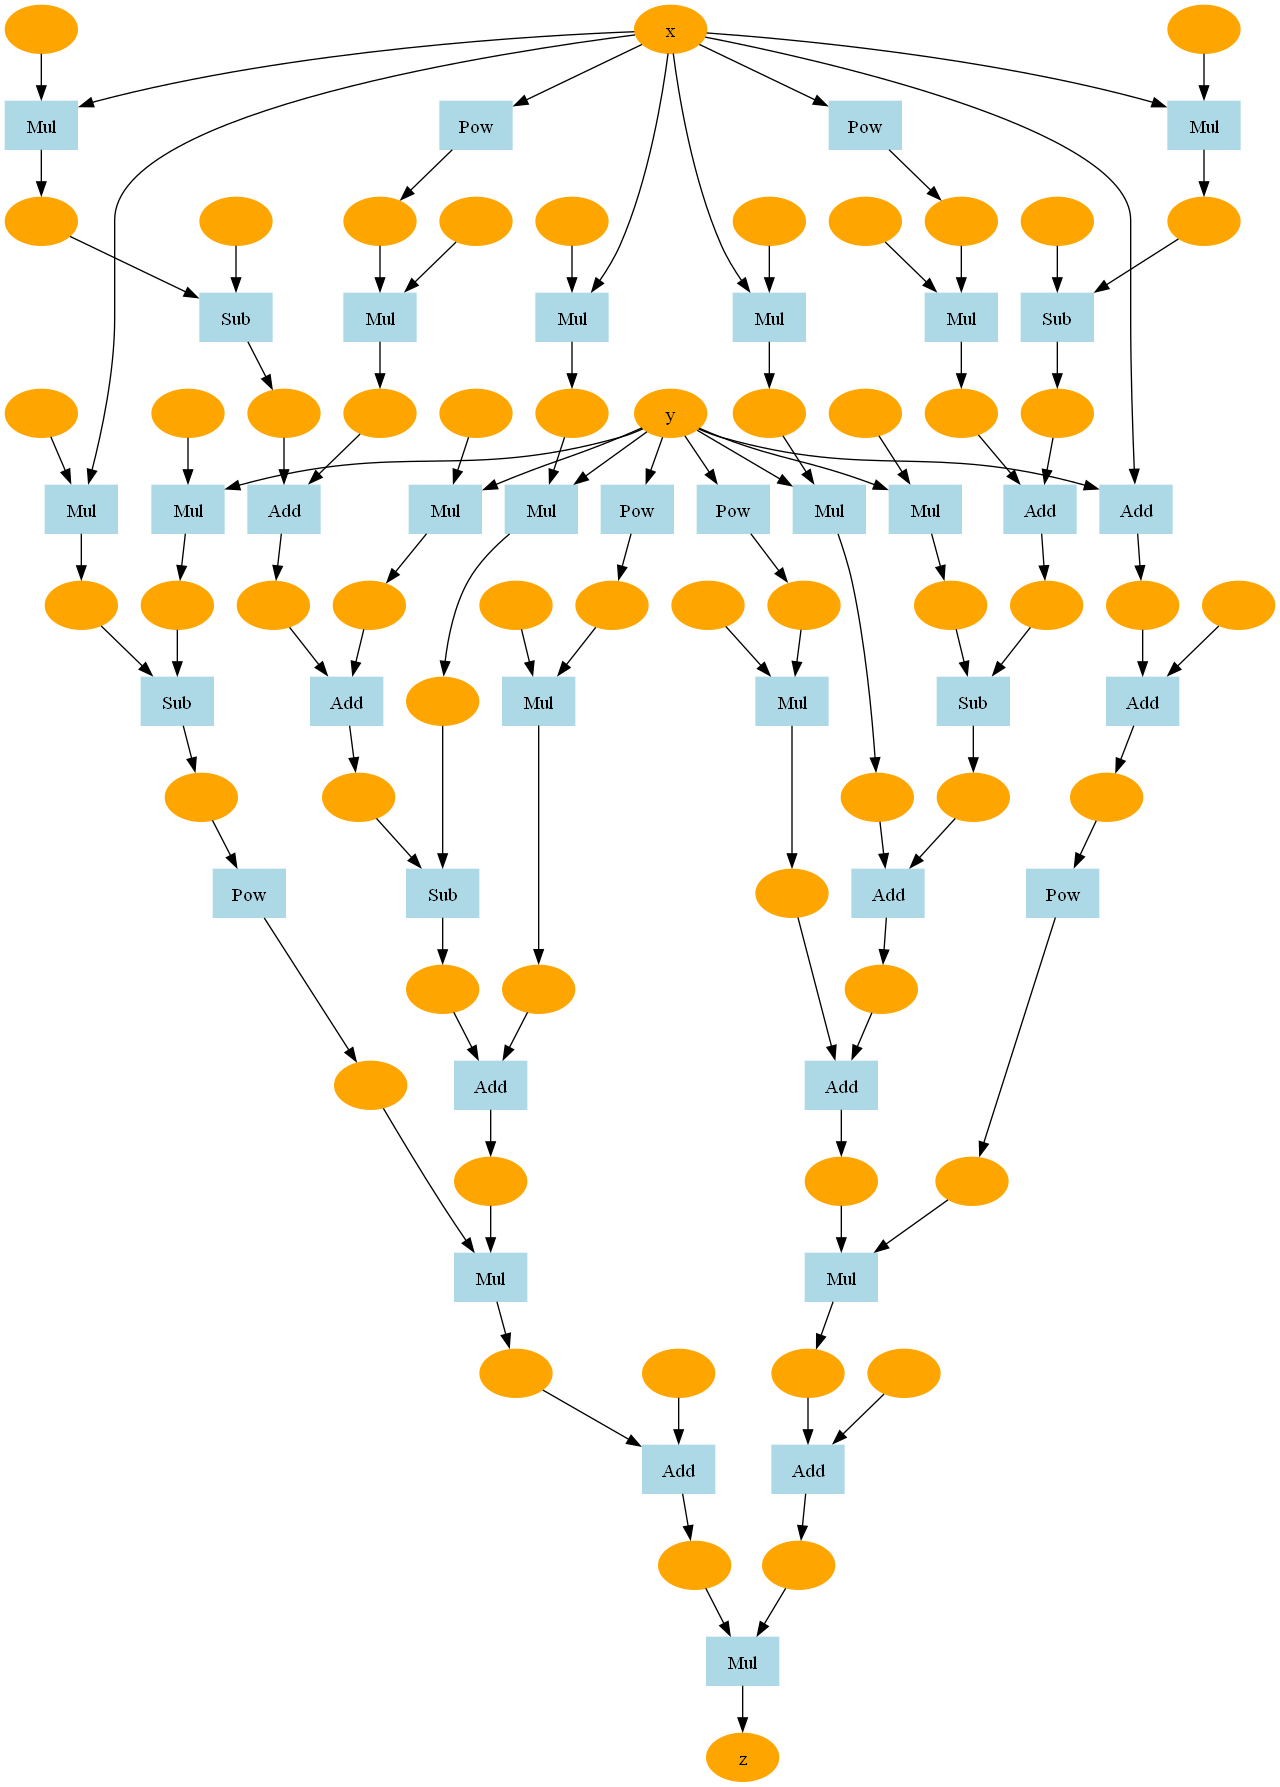

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph


def goldstein(x, y):
    z = (
        1
        + (x + y + 1) ** 2
        * (19 - 14 * x + 3 * x**2 - 14 * y + 6 * x * y + 3 * y**2)
    ) * (
        30
        + (2 * x - 3 * y) ** 2
        * (18 - 32 * x + 12 * x**2 + 48 * y - 36 * x * y + 27 * y**2)
    )
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

### step27

--- original sin ---
0.7071067811865476
0.7071067811865476
--- approximate my_sin ---
0.7071064695751781
0.7071032148228457


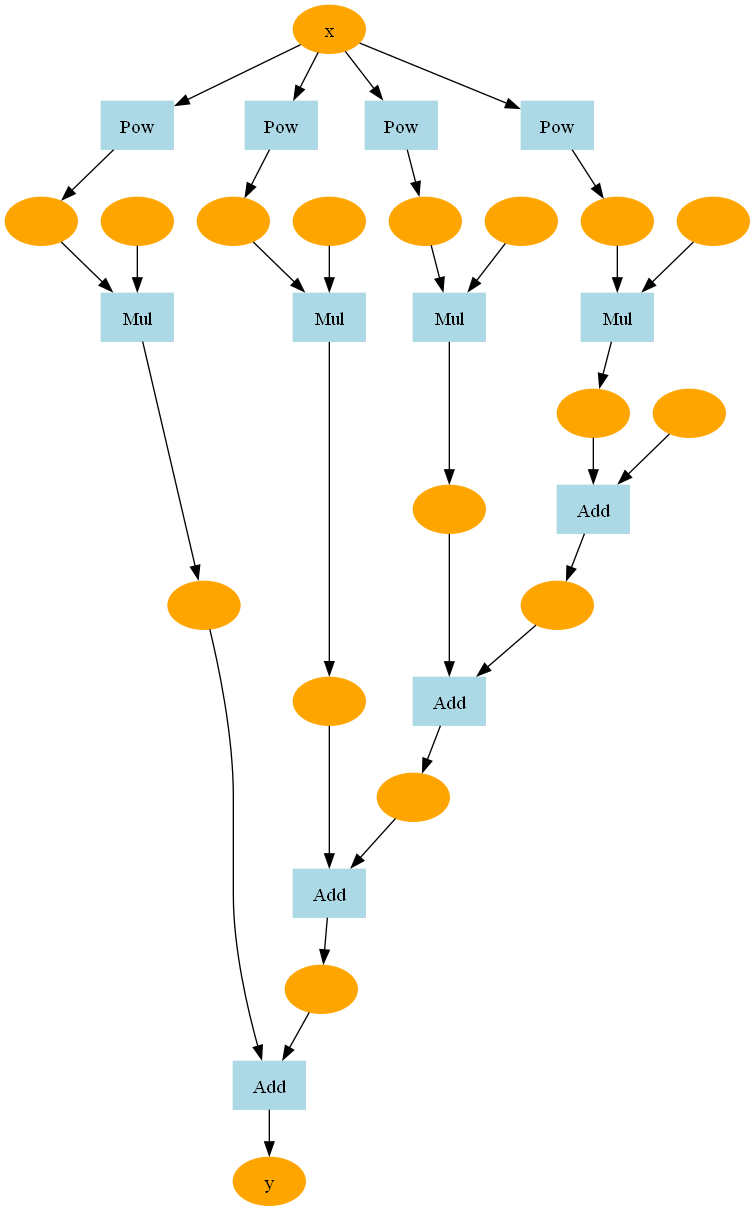

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))
import numpy as np
import math
from dezero import Variable, Function
from dezero.utils import plot_dot_graph

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx
    
def sin(x):
    return Sin()(x)

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward() # type: ignore

print('--- original sin ---')
print(y.data) # type: ignore
print(x.grad)


def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1)**i / math.factorial(2*i+1)
        t = c * x ** (2*i+1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward() # type: ignore
print('--- approximate my_sin ---')
print(y.data) # type: ignore
print(x.grad)

x.name = 'x'
y.name = 'y' # type: ignore
plot_dot_graph(y, verbose=False, to_file='my_sin.png')


### step28

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0**2)**2 + (1 - x0)**2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 10000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad # type: ignore
    x1.data -= lr * x1.grad # type: ignore



variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

### step29

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

def gx2(x):
    return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)

    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data) # type: ignore

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### step30

In [ ]:
# no code

### step31

In [ ]:
# no code

### step32

In [ ]:
# no code

### step33

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable


def f(x):
    y = x**4 - 2 * x**2  # type: ignore
    return y


x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data  # type: ignore

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### step34

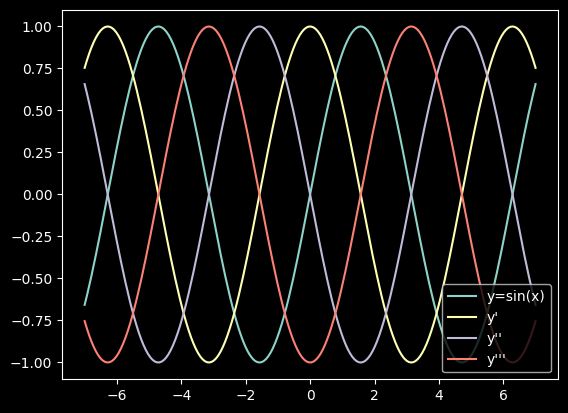

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])

plt.legend(loc='lower right')
plt.show()


### step35

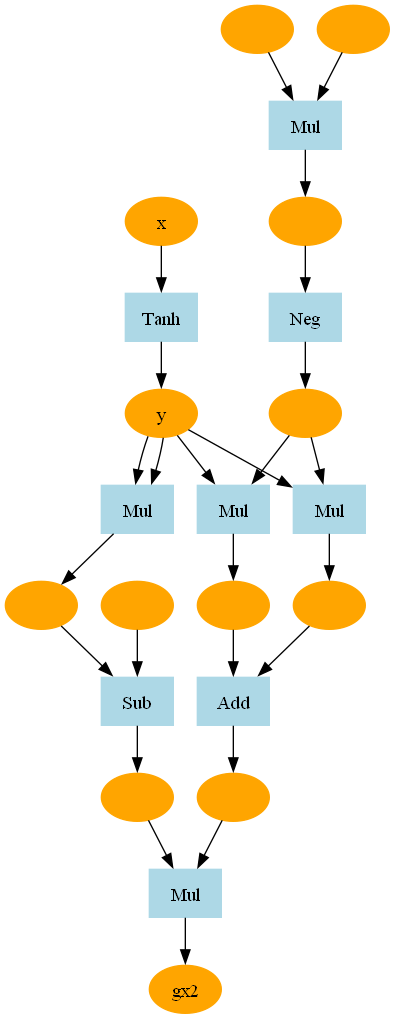

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 1

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

### step36

variable(100.0)


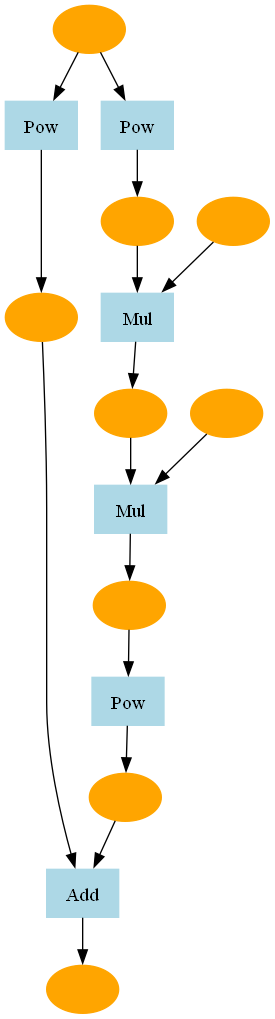

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

plot_dot_graph(z, verbose=False, to_file='step36.png')


### step37

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)

y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


### step38

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,)) 
y.backward(retain_grad=True)
print(x.grad)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


### step39

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward() # type: ignore
print(y)
print(x.grad)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward() # type: ignore
print(y)
print(x.grad)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward() # type: ignore
print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

variable(21)
variable([1 1 1 1 1 1])
variable(21)
variable([[1 1 1]
          [1 1 1]])
variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


### step40

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable

x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1 # type: ignore
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([3])


### step41

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.random.randn(2, 3))
w = Variable(np.random.randn(3, 4))
y = F.matmul(x, w)
y.backward()

print(x)
print(w)
print(y)
print(x.grad.shape)
print(w.grad.shape)

variable([[ 0.59039815  1.70147251  0.51565666]
          [ 0.57998305 -0.64581032  0.50728469]])
variable([[ 0.29263267 -0.01010415  0.36116908  0.84036558]
          [-1.39773356  0.60694591 -0.31039252  0.66453658]
          [-0.61430028 -1.26767898  0.416204   -1.11280522]])
variable([[-2.52220347  0.37304922 -0.10027242  1.05301559]
          [ 0.76076761 -1.0409063   0.62106055 -0.50627584]])
(2, 3)
(3, 4)


### step42

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

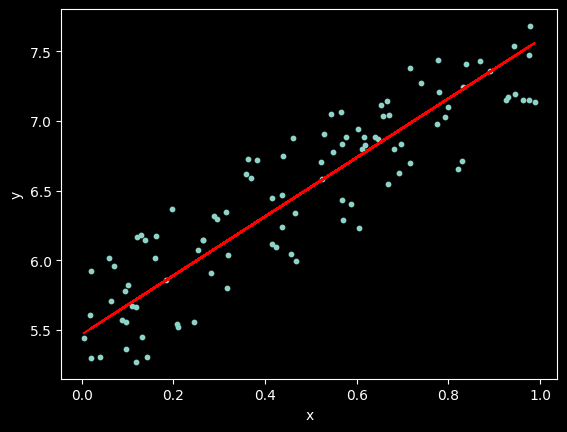

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
y_pred = predict(x)
plt.plot(x.data, y_pred.data, color='r')
plt.show()


### step43

variable(0.8473695850105871)
variable(0.2514286285183607)
variable(0.24759485466749878)
variable(0.23786120447054832)
variable(0.21222231333102953)
variable(0.16742181117834223)
variable(0.0968193261999272)
variable(0.07849528290602335)
variable(0.07749729552991157)
variable(0.07722132399559317)


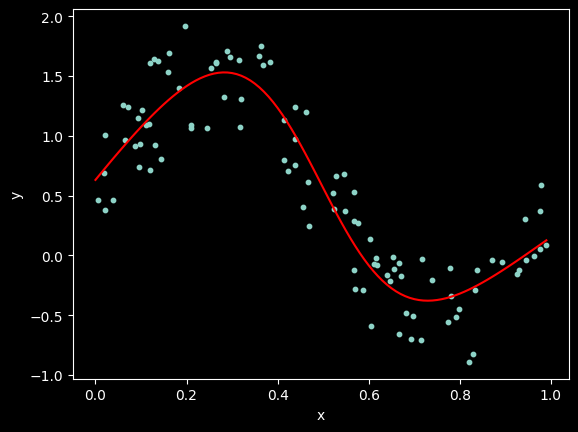

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H)) 
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()



### step44

In [ ]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import dezero.functions as F
import dezero.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)


def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y


lr = 0.2
iters = 10000


for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()
    l2.cleargrads()
    loss.backward() # type: ignore

    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)


variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


### step45

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import dezero.functions as F
import dezero.layers as L
from dezero import Model

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    

model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward() # type: ignore

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)



variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


### step46

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import dezero.functions as F
from dezero.models import MLP
from dezero import optimizers

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward() # type: ignore
    optimizer.update()
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355147)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185572)


### step47

In [ ]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
np.random.seed(0)
from dezero import Variable, as_variable
import dezero.functions as F
from dezero.models import MLP

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y # type: ignore

model = MLP((10, 3))

x = np.array([[0.2, -0.4]])
y = model(x)
p = softmax1d(y)
print(y)
print(p)

x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])

y = model(x)
p = F.softmax_simple(y)
print(y)
print(p)

loss = F.softmax_cross_entropy_simple(y, t)
loss.backward()
print(loss)

variable([[-0.61505778 -0.42790161  0.31733289]])
variable([[0.21068639 0.25404893 0.53526469]])
variable([[-0.61505778 -0.42790161  0.31733289]
          [-0.76395313 -0.2497645   0.18591382]
          [-0.52006391 -0.96254612  0.57818938]
          [-0.94252164 -0.50307479  0.17576323]])
variable([[0.21068639 0.25404893 0.53526469]
          [0.19019916 0.31806646 0.49173438]
          [0.21545395 0.13841619 0.64612986]
          [0.17820704 0.27655034 0.54524263]])
variable(1.4967442524053063)


### step48

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

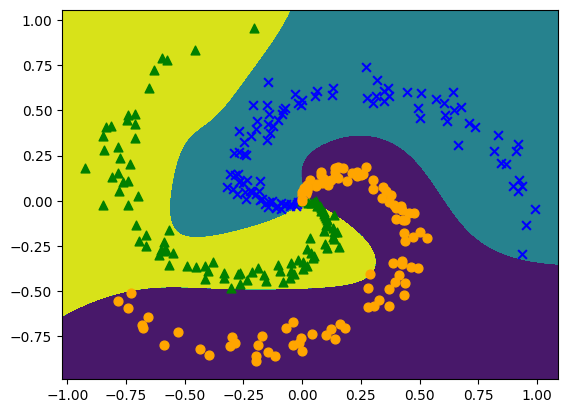

In [2]:
if "__file__" in globals():
    import os, sys

    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import math
import numpy as np
import dezero.functions as F
from dezero.models import MLP
from dezero import optimizers
import matplotlib.pyplot as plt
import dezero

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        batch_index = index[i * batch_size : (i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        y = model(batch_x)
        loss = F.softmax_cross_entropy_simple(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    avg_loss = sum_loss / data_size
    print(f"epoch {epoch+1}, loss {avg_loss:.2f}")


# Plot boundary area the model predict
h = 0.001
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.no_grad():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

# Plot data points of the dataset
N, CLS_NUM = 100, 3
markers = ["o", "x", "^"]
colors = ["orange", "blue", "green"]
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40, marker=markers[c], c=colors[c])

plt.show()

### step49

In [1]:
if "__file__" in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), ".."))

import numpy as np
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero.models import MLP
import math

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        batch_index = index[i * batch_size : (i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,